# Exploratory Data Analysis

Now that we have our raw data, the next main goal is getting the data in a form that can be ingested by a model. For this we will need three things:
1. **Good, clean data.** This is the biggest hurdle. Once we've processed the raw data into a form we can actually make use of, we will want to explore its quality.
2. **Labels.** In our case, we are looking to classify films by genre. This was pulled from the OMDb api with the rest of our data. 
3. **Features.** For now we will just do minor cleanup of the summaries from OMDb. The feature engineering we will save for the machine learning step, so that we can experiment with different numerical encoding techniques (bag-of-words, ord2vec, etc.).


## 1. Data cleaning

The actual plot and genre data from OMDb is already pretty clean, so the biggest potential problem to data quality is that the movie names we used as input to OMDb were pulled from Wikipedia. We saved a few flags while extracting data that recorded if there was no response from OMDb, and if there was a mismatch between the year used by OMDb and the year listed on Wikipedia. 

We will exclude from analysis all records where we didn't get any genre or plot. In the future we need to look at what we are excluding more carefully, as this is a may introduce additional bias to our modeling. Additionally, our script flagged year mismatches, which may be indicative of problematic data. From poking around the main effect this has is duplicating records where either OMDb or Wikipedia has the wrong release year. We will exclude these flagged films to avoid duplicates.

In [2]:
from collections import defaultdict
import glob
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

# Canonical cookie cutter start...
from dotenv import load_dotenv, find_dotenv
#find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [3]:
# files = glob.glob('../data/raw/omdb-movies-20181222/*.csv')
files = glob.glob('../data/raw/omdb-movies-20190122/*.csv')
dfs = [pd.read_csv(f) for f in files]
data_raw = pd.concat(dfs)

In [4]:
# Just looking at some rows...
data_raw = data_raw[
    data_raw['genre'].notnull() &
    data_raw['plot'].notnull() &
    data_raw['year_mismatch']
]
data_raw.head()

,imdbid,title,year,released,genre,actors,plot,response,year_mismatch
0,tt0051349,Ambush at Cimarron Pass,1958,01 Mar 1958,Western,"Scott Brady, Margia Dean, Clint Eastwood, Irvi...",The survivors of an Army patrol ambushed by In...,True,True
1,tt0051360,Andy Hardy Comes Home,1958,01 Jun 1959,Comedy,"Mickey Rooney, Patricia Breslin, Fay Holden, C...","Andy Hardy, now a grown man with a wife and ch...",True,True
2,tt0051362,Anna Lucasta,1958,01 Nov 1958,Drama,"Eartha Kitt, Sammy Davis Jr., Frederick O'Neal...",Young woman struggling with a sordid past find...,True,True
3,tt0051364,"Another Time, Another Place",1958,06 Jun 1958,"Drama, Romance, War","Lana Turner, Barry Sullivan, Glynis Johns, Sea...",Lana Turner is a female American journalist wh...,True,True
4,tt0051369,Apache Territory,1958,01 Sep 1958,"Action, Western","Rory Calhoun, Barbara Bates, John Dehner, Caro...","Logan Cates, a drifter, is traveling through A...",True,True


In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23137 entries, 0 to 360
Data columns (total 9 columns):
imdbid           23137 non-null object
title            23137 non-null object
year             23137 non-null object
released         22817 non-null object
genre            23137 non-null object
actors           22914 non-null object
plot             23137 non-null object
response         23137 non-null bool
year_mismatch    23137 non-null bool
dtypes: bool(2), object(7)
memory usage: 1.5+ MB


## 2. Data exploration

### 2.1. Distribution of genres

First let's look at how our labels are distributed among our data. 

In [6]:
# Get total counts of genres
genres = defaultdict(int)
for each in data_raw['genre']:
    for g in each.split(','):
        g = g.lower().strip()
        genres[g] += 1

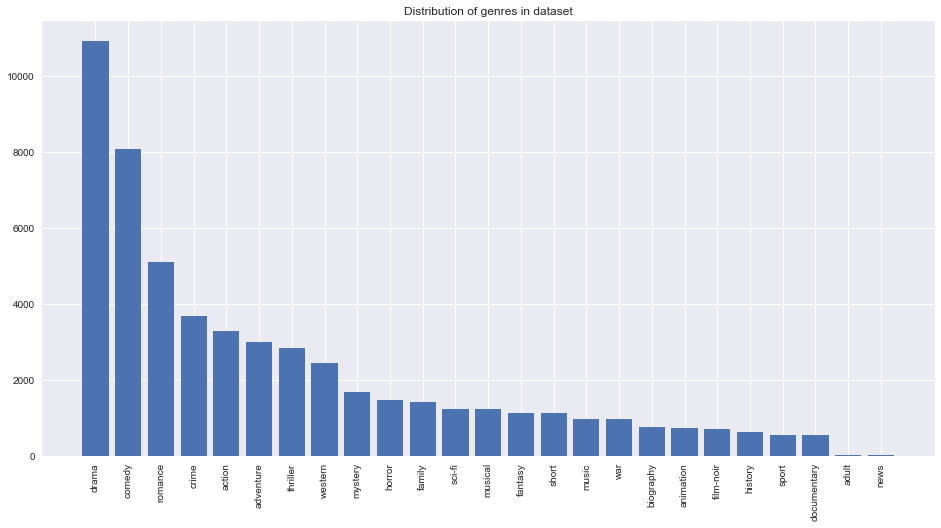

In [8]:
# Plot count by genre
genres_sort = [(k, v) for k, v in genres.items()]
genres_sort = sorted(genres_sort, key=lambda x: x[1], reverse=True)
count = [x[1] for x in genres_sort]
labels = [x[0] for x in genres_sort]

idx = np.arange(len(count))

plt.figure(figsize=(16, 8))
plt.bar(idx, count)
plt.xticks(idx, labels, rotation=90)
plt.title('Distribution of genres in dataset')
plt.show()

A few things jump out for further investigation:
1. Have both music and musical. Need to investigate if these are actually different.
2. Some genres seem inherently secondary, like 'war' or 'sport'. Should investigate if they pair with other genres typically.
3. The 'adult' and 'news' genres do not have enough representation to predict. 
4. The most popular genres are more generic and the least popular genres are more specific. This is likely because dramas, comedies, etc. are given a second genre, such as drama + crime, comedy + romance, etc.

## 2.2. Associations among genres

In order to get a more fine-grained understanding of what's going on in the data, let's isolate the label and the plot data, and one-hot-encode the genre labels.

In [14]:
data_genre = data_raw.loc[:, ['imdbid', 'title', 'genre']]
data_plot = data_raw.loc[:, ['imdbid', 'title', 'plot']]
data_plot = data_plot.set_index(['imdbid', 'title'])

In [15]:
# Add columns for genre bits
for g in genres.keys():
    data_genre[g] = data_genre['genre'].apply(
        lambda x: g in [y.lower().strip() for y in x.split(',')]     
    ).astype(int)
data_genre.drop('genre', axis=1, inplace=True)
data_genre = data_genre.set_index(['imdbid', 'title'])

In [16]:
# Verify encoding results
data_genre.head()

,,western,comedy,drama,romance,war,action,horror,sci-fi,adventure,history,...,mystery,thriller,sport,short,family,biography,animation,documentary,adult,news
imdbid,title,,,,,,,,,,,,,,,,,,,,,
tt0051349,Ambush at Cimarron Pass,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0051360,Andy Hardy Comes Home,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0051362,Anna Lucasta,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0051364,"Another Time, Another Place",0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0051369,Apache Territory,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
def cooccurrence_matrix(df, normalized=False):
    """Get 2x2 matrix of cooccurrences.

       Parameters
       ----------
       normalized : bool, optional (default=True)
           Whether or not to normalize by total size of each column

    """
    pairs = pd.DataFrame(
        None, 
        columns=df.columns, 
        index=df.columns
    )
    norm = 1
    for col in df:
        if normalized:
            norm = df[col].sum()
        pairs[col] = \
            df.groupby(col).sum().iloc[1] / norm
        
    return pairs

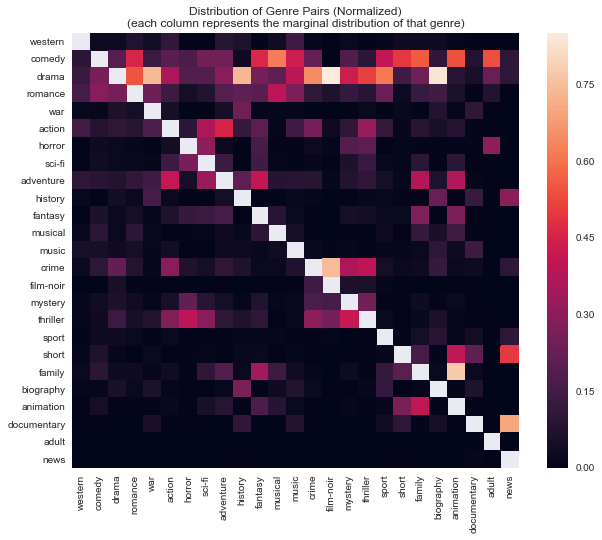

In [20]:
normalized = True
genre_pairs = cooccurrence_matrix(data_genre, normalized=normalized)
plt.figure(figsize=(10, 8))
sns.heatmap(genre_pairs)
title = 'Distribution of Genre Pairs'
if normalized:
    title += (
        ' (Normalized)\n' 
        '(each column represents the marginal distribution of that genre)'
    )
plt.title(title)
plt.show()

A few notes:
1. News films tend to also be documentaries, shorts, or history films (big surprise).
2. Animation tends to also be family, shorts, adventure, comedy (again, big surprise).
3. The big horizontal blob: Everything tends to also be a comedy, romance, or drama (expected because comedies, romances, and dramas are highly represented in these data).
4. There are a few blobs on the main diagonal (which suggests that films in the blob tend to always pair off with each other):
    - the crime-noir-mystery-thriller blob
    - the family, short, animation blob
5. Westerns tend to only be westerns. 
6. History, noir, thriller, biography, documentary, and news are basically never comedy (very serious).

In [136]:
# Exporting for modeling time
data_genre.to_csv('../data/processed/genres_labels.csv')
data_plot.to_csv('../data/processed/film_plots.csv')